# Árboles de decisión: Churn compañía de servicios de telefonía móvil

Vamos a aplicar un modelo de clasificación de árboles de decisión a un dataset que describe los clientes de una compañía que presta servicios de telefonía móvil que se han abandonado o no la compañía para irse a la competencia.

Importamos las librerías que vamos a utilizar

In [51]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import tree, datasets, metrics
#from sklearn import neighbors, datasets, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
import seaborn as sns
import math

## Entendimiento de los datos

Cargamos los datos para entenderlos

In [4]:
data = pd.read_csv("D:\OneDrive - Tecnoquimicas\99. PERSONAL\Formación\Maestria\Semestre 1\Fundamentos de Analitica I\8-06-churn.csv", sep=';', na_values=".")
print(data.shape)
data.head(5)

(20000, 12)


,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**Parte 1**:
* Determine el número de registros, de variables, sus tipos ideales/reales, y sus rangos
* Determine el baseline y su accuracy. ¿Están balanceados los datos?
* ¿Encuentran algún problema con los datos (missing values, datos inválidos, etc.)?
* Si fuésemos a utilizar K-NN, ¿debería hacerse algún pretratamiento de los datos?

El método **describe** permite obtener un dataframe con una descripción de las variables de un dataframe analizado. Para cada variable encontramos el número de registros validos (*count*).

Además, si se trata de una variable categórica, se puede obtener el número de clases posibles (*unique*), la clase mayoritaria (*top*) y la frecuencia de la clase mayoritaria (*freq*).

Y, si se trata de una variable numérica, se puede obtener el promedio (*mean*), desviación estándar (*std*), los valores mínimos (*min*) y máximos (*max*) y los cuartiles (*25%*, *50%* y *75%*).

In [5]:
data.describe(include="all")

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
count,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000,20000,20000,20000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,2
top,one,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_unsat,little,considering,STAY
freq,10048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7909,7875,7920,10148
mean,NaN,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,NaN,NaN,NaN,NaN
std,NaN,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,NaN,NaN,NaN,NaN
min,NaN,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,NaN,NaN,NaN,NaN
50%,NaN,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,NaN,NaN,NaN,NaN
75%,NaN,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,NaN,NaN,NaN,NaN


In [6]:
data.LEAVE.describe()

count     20000
unique        2
top        STAY
freq      10148
Name: LEAVE, dtype: object

In [7]:
data.LEAVE.describe()['freq'] / data.LEAVE.describe()['count']

0.5074

In [8]:
data.LEAVE.value_counts()

STAY     10148
LEAVE     9852
Name: LEAVE, dtype: int64

<AxesSubplot:>

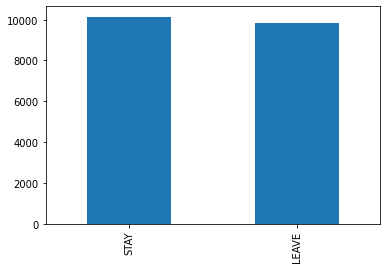

In [9]:
data.LEAVE.value_counts().plot.bar()

.
.
.

RESPONDER AQUI A LAS PREGUNTAS DE LA PARTE 1.
.
.
.

**Parte 2**:

Utilizando pandas y matplotlib, analice la distribución de las variables independientes con respecto a los valores de la variable objetivo LEAVE y STAY. Trate de encontrar patrones en plots univariados (densidad) y Bivariados (scatterplots) para las variables numéricas, y gráficos de barras de conteo para las categóricas.

In [10]:
var_indep_cat = ['COLLEGE', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL',
       'CONSIDERING_CHANGE_OF_PLAN', 'LEAVE']

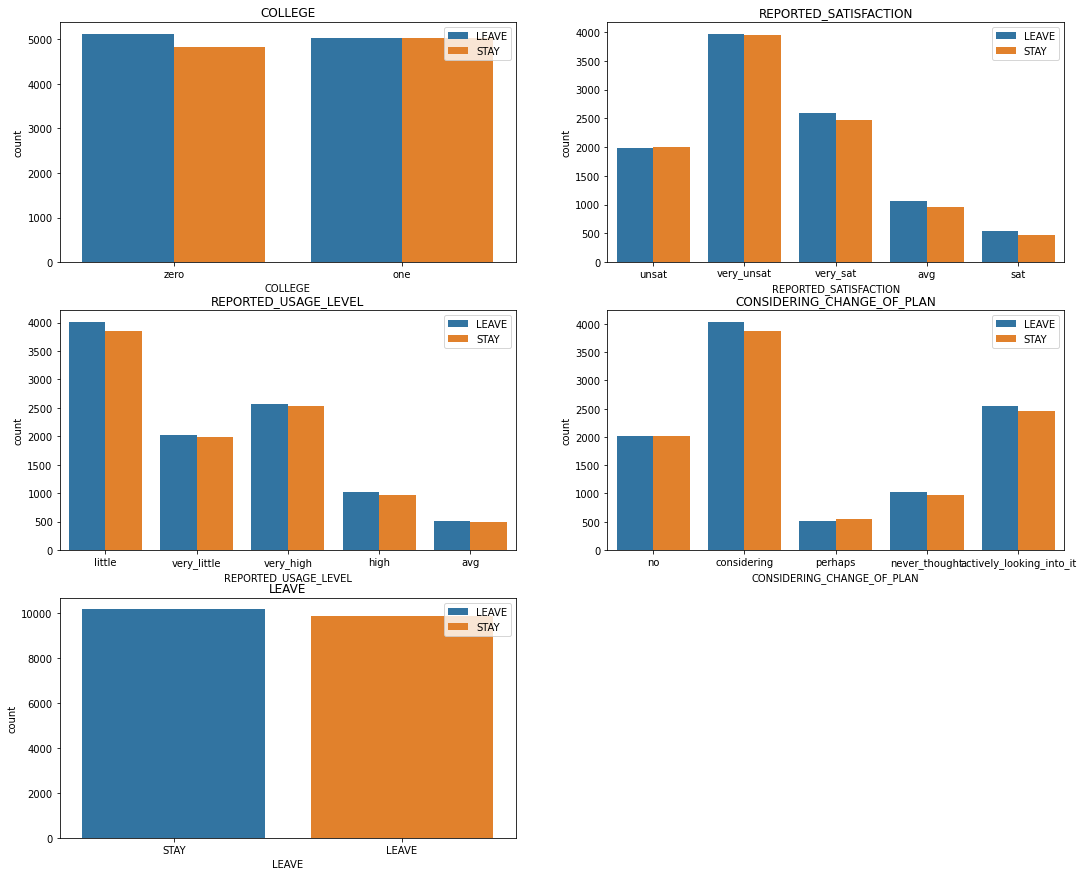

In [11]:
fig = plt.figure(figsize=(18,15))
i=1
for var_cat in var_indep_cat:
    ax = fig.add_subplot(math.ceil(len(var_indep_cat)/2), 2, i)
    sns.countplot(x=var_cat, hue="LEAVE", data=data)
    plt.title(var_cat)
    plt.legend(['LEAVE', 'STAY'])
    i+=1
    

In [12]:
var_indep_cat.remove('LEAVE')

In [13]:
var_indep_num = ['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
                 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION']

In [14]:
import warnings
warnings.filterwarnings('ignore')

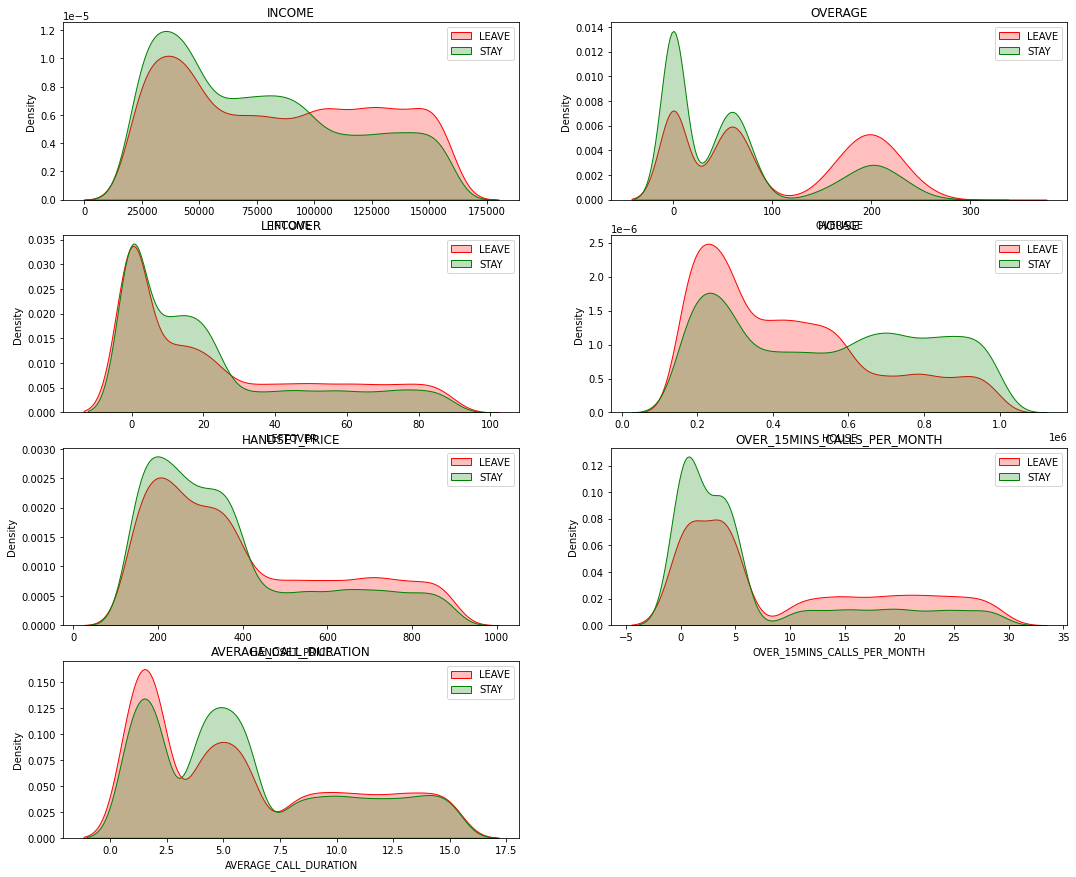

In [15]:
fig = plt.figure(figsize=(18,15))
i=1
for var_num in var_indep_num:
    ax = fig.add_subplot(math.ceil(len(var_indep_num)/2), 2, i)
    sns.kdeplot(data[data['LEAVE']=='LEAVE'][var_num], shade=True, color='r', ax=ax);
    sns.kdeplot(data[data['LEAVE']=='STAY'][var_num], shade=True, color='g', ax=ax);
    plt.title(var_num)
    plt.legend(['LEAVE', 'STAY'])
    i+=1

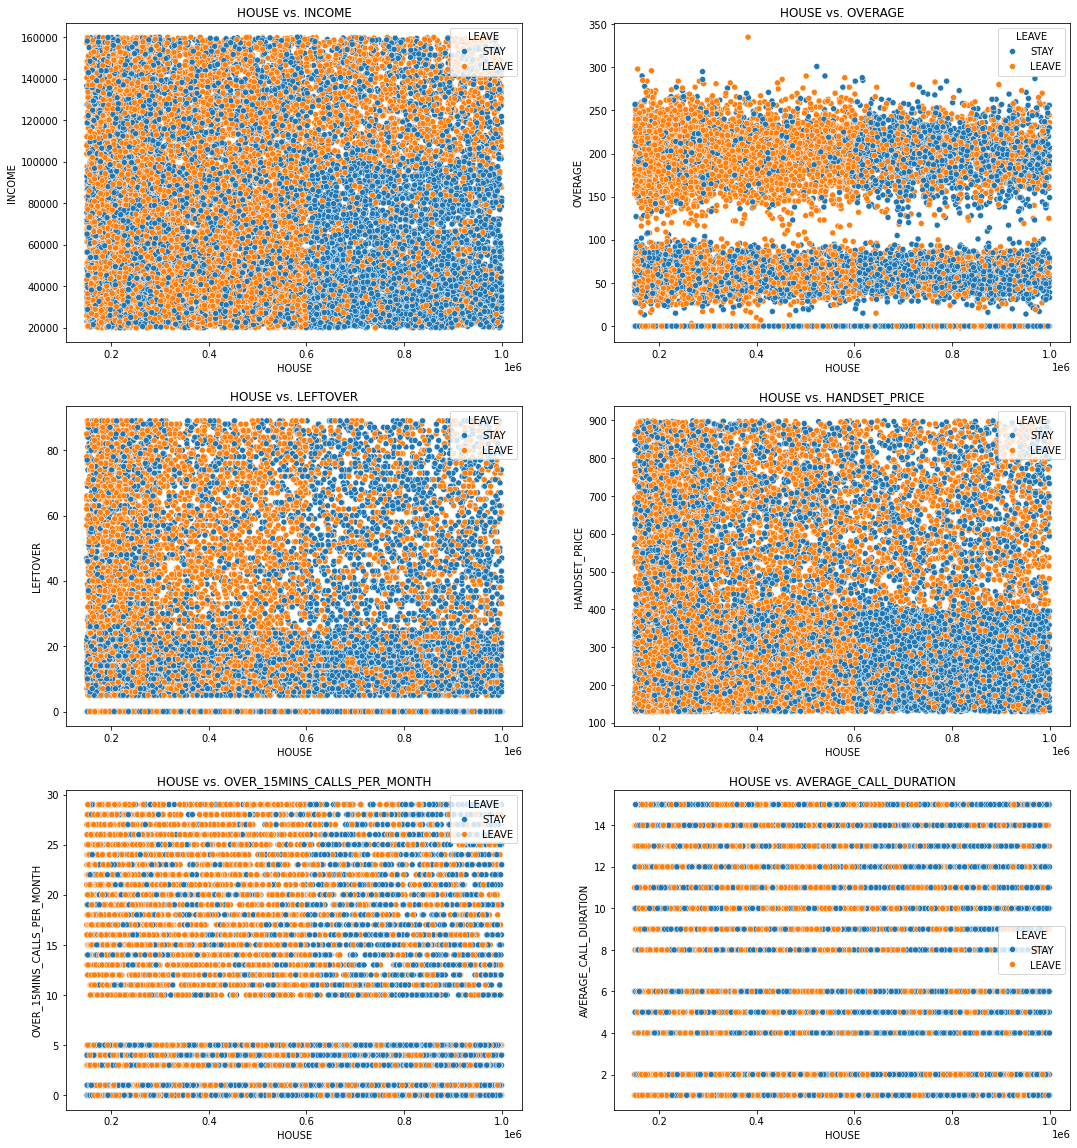

In [16]:
fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(3, 2, 1)
sns.scatterplot(x="HOUSE", y="INCOME", hue="LEAVE", data=data, ax=ax)
plt.title("HOUSE vs. INCOME")
ax = fig.add_subplot(3, 2, 2)
sns.scatterplot(x="HOUSE", y="OVERAGE", hue="LEAVE", data=data, ax=ax)
plt.title("HOUSE vs. OVERAGE")
ax = fig.add_subplot(3, 2, 3)
sns.scatterplot(x="HOUSE", y="LEFTOVER", hue="LEAVE", data=data, ax=ax)
plt.title("HOUSE vs. LEFTOVER")
ax = fig.add_subplot(3, 2, 4)
sns.scatterplot(x="HOUSE", y="HANDSET_PRICE", hue="LEAVE", data=data, ax=ax)
plt.title("HOUSE vs. HANDSET_PRICE")
ax = fig.add_subplot(3, 2, 5)
sns.scatterplot(x="HOUSE", y="OVER_15MINS_CALLS_PER_MONTH", hue="LEAVE", data=data, ax=ax)
plt.title("HOUSE vs. OVER_15MINS_CALLS_PER_MONTH")
ax = fig.add_subplot(3, 2, 6)
sns.scatterplot(x="HOUSE", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=data, ax=ax)
plt.title("HOUSE vs. AVERAGE_CALL_DURATION")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(3, 2, 1)
sns.scatterplot(x="INCOME", y="OVERAGE", hue="LEAVE", data=data, ax=ax)
plt.title("INCOME vs. OVERAGE")
ax = fig.add_subplot(3, 2, 2)
sns.scatterplot(x="INCOME", y="LEFTOVER", hue="LEAVE", data=data, ax=ax)
plt.title("INCOME vs. LEFTOVER")
ax = fig.add_subplot(3, 2, 3)
sns.scatterplot(x="INCOME", y="HANDSET_PRICE", hue="LEAVE", data=data, ax=ax)
plt.title("INCOME vs. HANDSET_PRICE")
ax = fig.add_subplot(3, 2, 4)
sns.scatterplot(x="INCOME", y="OVER_15MINS_CALLS_PER_MONTH", hue="LEAVE", data=data, ax=ax)
plt.title("INCOME vs. OVER_15MINS_CALLS_PER_MONTH")
ax = fig.add_subplot(3, 2, 5)
sns.scatterplot(x="INCOME", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=data, ax=ax)
plt.title("INCOME vs. AVERAGE_CALL_DURATION")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="OVERAGE", y="LEFTOVER", hue="LEAVE", data=data, ax=ax)
plt.title("OVERAGE vs. LEFTOVER")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="OVERAGE", y="HANDSET_PRICE", hue="LEAVE", data=data, ax=ax)
plt.title("OVERAGE vs. HANDSET_PRICE")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="OVERAGE", y="OVER_15MINS_CALLS_PER_MONTH", hue="LEAVE", data=data, ax=ax)
plt.title("OVERAGE vs. OVER_15MINS_CALLS_PER_MONTH")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="OVERAGE", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=data, ax=ax)
plt.title("OVERAGE vs. AVERAGE_CALL_DURATION")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="LEFTOVER", y="HANDSET_PRICE", hue="LEAVE", data=data, ax=ax)
plt.title("LEFTOVER vs. HANDSET_PRICE")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="LEFTOVER", y="OVER_15MINS_CALLS_PER_MONTH", hue="LEAVE", data=data, ax=ax)
plt.title("LEFTOVER vs. OVER_15MINS_CALLS_PER_MONTH")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="LEFTOVER", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=data, ax=ax)
plt.title("LEFTOVER vs. AVERAGE_CALL_DURATION")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(x="HANDSET_PRICE", y="OVER_15MINS_CALLS_PER_MONTH", hue="LEAVE", data=data, ax=ax)
plt.title("HANDSET_PRICE vs. OVER_15MINS_CALLS_PER_MONTH")
ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(x="HANDSET_PRICE", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=data, ax=ax)
plt.title("HANDSET_PRICE vs. AVERAGE_CALL_DURATION")
plt.show()

Algunos de los plots no son fáciles de interpretar porque los puntos están uno encima de otro.
Para estos casos se puede agregar un poco de ruido (**jitter**) a los puntos. 
Vamos a agregarlo a mano para el siguiente plot (increiblemente Python no tiene esta funcionalidad!!!).
Veamos como sería sin el jitter.

In [ ]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(x="OVER_15MINS_CALLS_PER_MONTH", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=data, ax=ax)
plt.title("OVER_15MINS_CALLS_PER_MONTH vs. AVERAGE_CALL_DURATION")
plt.show()

Ahora veamos con el jitter (creado a mano), combinado con una reducción en el tamaño de los puntos para que se vea una mayor cantidad de puntos.

In [ ]:
d2 = data[["OVER_15MINS_CALLS_PER_MONTH", "AVERAGE_CALL_DURATION", "LEAVE"]]
jitter = 0.3
d2.OVER_15MINS_CALLS_PER_MONTH = data.OVER_15MINS_CALLS_PER_MONTH + np.random.normal(scale=jitter, size=20000)
d2.AVERAGE_CALL_DURATION = data.AVERAGE_CALL_DURATION + np.random.normal(scale=jitter, size=20000)

In [ ]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(x="OVER_15MINS_CALLS_PER_MONTH", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=d2, ax=ax, size=1)
plt.title("OVER_15MINS_CALLS_PER_MONTH vs. AVERAGE_CALL_DURATION")
plt.show()

# Clasificación a partir un árbol de decisión

Los árboles de decisión permiten utilizar tanto las variables predictivas categóricas como las numéricas.
No todas las variables van a ser útiles. El árbol se va a encargar de encontrar la mejor variable a utilizar en el contexto del subconjunto de datos de cada rama.

Veamos cómo se crea un árbol de decisión en scikit-learn, y algunos de los parámetros más importantes:

In [60]:
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)

**Nota editorial**: scikit-learn soporta en sus árboles de decisión solamente variables independientes numéricas!!!!! Toca entonces utilizar un encoding (one hot).

In [18]:
data_cat_one_hot = pd.get_dummies(data[var_indep_cat], prefix=var_indep_cat)
X = data[var_indep_num].join(data_cat_one_hot)
y = data['LEAVE']
X.shape

(20000, 24)

Quedaron 24 variables independientes.

In [19]:
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [20]:
ctree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Una vez el árbol es aprendido, se puede consultar diferentes atributos.
El mas interesante, aparte del árbol en sí, es el que asocia un índice de importancia a los atributos independientes en la clasificación:

In [21]:
ctree.feature_importances_

array([0.17437343, 0.14944112, 0.09124796, 0.19132363, 0.13132086,
       0.05914209, 0.04566898, 0.00888597, 0.01150407, 0.00899971,
       0.00531261, 0.00895118, 0.01187495, 0.01149387, 0.00462386,
       0.00871771, 0.01189083, 0.00972819, 0.00831384, 0.01212178,
       0.01153006, 0.00635061, 0.01110528, 0.00607741])

In [33]:
X.columns

Index(['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION', 'COLLEGE_one',
       'COLLEGE_zero', 'REPORTED_SATISFACTION_avg',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_avg', 'REPORTED_USAGE_LEVEL_high',
       'REPORTED_USAGE_LEVEL_little', 'REPORTED_USAGE_LEVEL_very_high',
       'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')

Encontramos entonces que las variables en orden de importancia son:

In [34]:
X.columns[np.argsort(-ctree.feature_importances_)]

Index(['HOUSE', 'INCOME', 'OVERAGE', 'HANDSET_PRICE', 'LEFTOVER',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION_very_unsat', 'COLLEGE_zero',
       'CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_USAGE_LEVEL_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering', 'REPORTED_USAGE_LEVEL_high',
       'REPORTED_SATISFACTION_unsat', 'REPORTED_USAGE_LEVEL_very_high',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'COLLEGE_one',
       'REPORTED_SATISFACTION_avg', 'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought', 'REPORTED_SATISFACTION_sat',
       'CONSIDERING_CHANGE_OF_PLAN_perhaps', 'REPORTED_USAGE_LEVEL_avg'],
      dtype='object')

Vamos ahora a visualizar el árbol aprendido (para hacerlo, se necesita preinstalar la aplicación graphviz).

In [58]:
import pydotplus
from IPython.display import Image  
from six import StringIO  

In [62]:
dot_data = StringIO()
tree.export_graphviz(ctree, 
                     filled=True, rounded=True,  #nodos redondeados y coloreados
                     class_names=ctree.classes_,
                     feature_names=X_train.columns,  
                     out_file=dot_data,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

AttributeError: 'DecisionTreeClassifier' object has no attribute 'classes_'

La imágen es demasiado grande para poder visualizarla aquí, vamos a guardarla un archivo y abrirla en un visor externo que permita hacer zoom.

In [ ]:
# Create PNG
graph.write_png("arbol.png")

Como se puede ver el árbol es increiblemente grande y complejo, pues no se especificó ninguna manera de limitar su crecimiento.

## Evaluación del modelo

Ya tenemos el modelo "aprendido" con el dataset de 20000 instancias.
Vamos ahora a evaluarlo sobre ese mismo dataset para poder ver los éxitos y errores de la predicción. 

In [ ]:
y_pred = ctree.predict(X_test)

In [ ]:
cm= metrics.confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matriz de confusión para K=5")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, y_test.unique())
plt.yticks(tick_marks, y_test.unique())
plt.show()

In [ ]:
print(cm)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))
print("Precisión     : ", metrics.precision_score(y_test, y_pred, "LEAVE", average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, "LEAVE", average='macro'))
VN = np.sum(cm[1:3,1:3])
FP = np.sum(cm[0,1:3])
specificity = VN/(VN+FP)
print("Especificidad : ", specificity)
print("F1-score      : ", metrics.f1_score(y_test, y_pred, "LEAVE", average='macro'))


Con el árbol completo, obtuvimos un nivel de accuracy del 61.68%, cuando el baseline era de 50.74%.

## Overfitting: poda del árbol

Vamos a ver que hubiera pasado si limitamos el crecimiento del árbol (prepoda), controlando la profundidad del árbol y el mínimo número de registros de un nodo para permitir el particionamiento.

**Parte 3**:

Modifiquen el parámetro **criterion** y los parámetros de pre-poda buscando una mejor exactitud del modelo:
- **max_depth**: entre mas grande el valor, el árbol será más complejo (más número de niveles de profundidad)
- **min_samples_split**: entre mas grande el valor, el árbol será más sencillo (se necesita tener más registros en un nodo para poder particionarlo)
- **min_samples_leaf**: entre mas grande el valor, el árbol será más sencillo (se necesita tener más registros en una hoja para poder aceptarla, si no se llega a esa cardinalidad, no se permite el partionamiento de su nodo padre) 
- **min_impurity_decrease**: entre mas grande el valor, el árbol será más sencillo (un nivel de impureza bajo inferior a este umbral no desatará un particionamiento. 


In [27]:
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos
#    max_depth=,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
#    min_samples_split=, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
#    min_samples_leaf=,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
#    max_leaf_nodes=, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)
ctree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [28]:
y_pred = ctree.predict(X_test)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))

Exactitud:  0.62


In [41]:
dot_data = StringIO()
tree.export_graphviz(ctree, 
                     filled=True, rounded=True,  #nodos redondeados y coloreados
                     class_names=ctree.classes_,
                     feature_names=X_train.columns,  
                     out_file=dot_data,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: name 'StringIO' is not defined

Podríamos seguir mejorando el árbol buscando un tuning de la prepoda mas complejo con los demás parámetros.

Podemos intentar con otro tipo de modelos, e.g KNN.

In [38]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1234)
knn = KNeighborsClassifier(n_neighbors=300)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.632
Kappa    :  0.26713835783894757


También con un modelo Naive Bayes 

In [39]:
from sklearn.naive_bayes import GaussianNB
np.random.seed(1234)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.6443333333333333
Kappa    :  0.2876728119443984


## Modelos de ensamble: bagging, random forest, boosting

## Bagging

Vamos ahora a crear un modelo de ensamble que utiliza muchos modelos de árboles sencillos que pone a votar para encontrar una decisión consensuada.

In [64]:
from sklearn.ensemble import BaggingClassifier
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos
    max_depth=7,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=1000, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)
bagging = BaggingClassifier(estimator = ctree,   # Por defecto un decision tree 
                            n_estimators=200,          # Número de modelos a crear
                            max_samples=0.7,          # Número o % de registros de la muestra de aprendizaje
                            max_features=0.7,         # Número o % de atributos de la muestra de aprendizaje
                            bootstrap=True,           # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                            bootstrap_features=False, # Utilizar reemplazo en el muestreo de los atributos de aprendizaje
                            oob_score=False,          # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
                            n_jobs=2,                 # Número de cores a utilizar
                            random_state=None,        # random seed para el generador aleatorio
                            verbose=0)                # controla la cantidad de información a reportar


In [65]:
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.7016666666666667
Kappa    :  0.4039153106850012


Podemos hacer bagging de otro tipo de estimadores de base, por ejemplo KNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1234)
bagging = BaggingClassifier(base_estimator = KNeighborsClassifier(),   # Por defecto un decision tree 
                            n_estimators=50,          # Número de modelos a crear
                            max_samples=0.5,          # Número o % de registros de la muestra de aprendizaje
                            max_features=0.5,         # Número o % de atributos de la muestra de aprendizaje
                            bootstrap=True,           # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                            bootstrap_features=False, # Utilizar reemplazo en el muestreo de los atributos de aprendizaje
                            oob_score=False,          # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
                            n_jobs=2,                 # Número de cores a utilizar
                            random_state=None,        # random seed para el generador aleatorio
                            verbose=0)                # controla la cantidad de información a reportar

bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1234)
rforest = RandomForestClassifier(n_estimators=100,     #Número de modelos a crear 
                                criterion='entropy', # el criterio de particionamiento de un conjunto de datos
                                max_depth=6,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
                                min_samples_split=1000, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
                                min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
                                max_features=('auto'), # Número o % de atributos de la muestra de aprendizaje
                                max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
                                min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
                                bootstrap=True,      # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                                oob_score=True,     # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
                                n_jobs=2,            # Número de cores a utilizar
                                random_state=None,   # random seed para el generador aleatorio
                                verbose=0)           # controla la cantidad de información a reportar
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

In [ ]:
rforest.oob_score_

Encontramos que las variables en orden de importancia son:

In [ ]:
X.columns[np.argsort(-rforest.feature_importances_)]

## Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import zero_one_loss
np.random.seed(1234)

numModelos = 400
ada_10 = AdaBoostClassifier(base_estimator=None,  #Por defecto se trata de decision stumps
                         n_estimators=numModelos,     #Número de modelos a crear
                         algorithm='SAMME',
                         learning_rate=1.0)    #Reduce la importancia de los modelos mas recientes
ada_10.fit(X_train, y_train)
ada_02 = AdaBoostClassifier(base_estimator=None,  #Por defecto se trata de decision stumps
                         n_estimators=numModelos,     #Número de modelos a crear
                        algorithm='SAMME',
                         learning_rate=0.2)    #Reduce la importancia de los modelos mas recientes

ada_02.fit(X_train, y_train)
ada_005 = AdaBoostClassifier(base_estimator=None,  #Por defecto se trata de decision stumps
                         n_estimators=numModelos,     #Número de modelos a crear
                         algorithm='SAMME',
                         learning_rate=0.05)    #Reduce la importancia de los modelos mas recientes
ada_005.fit(X_train, y_train)

In [ ]:
ada_errores_test_10 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_10.staged_predict(X_test)):
    ada_errores_test_10[i] = 1-zero_one_loss(y_pred, y_test)
ada_errores_train_10 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_10.staged_predict(X_train)):
    ada_errores_train_10[i] = 1-zero_one_loss(y_pred, y_train)

In [ ]:
ada_errores_test_02 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_02.staged_predict(X_test)):
    ada_errores_test_02[i] = 1-zero_one_loss(y_pred, y_test)
ada_errores_train_02 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_02.staged_predict(X_train)):
    ada_errores_train_02[i] = 1-zero_one_loss(y_pred, y_train)

In [ ]:
ada_errores_test_005 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_005.staged_predict(X_test)):
    ada_errores_test_005[i] = 1-zero_one_loss(y_pred, y_test)

ada_errores_train_005 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_005.staged_predict(X_train)):
    ada_errores_train_005[i] = 1-zero_one_loss(y_pred, y_train)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(numModelos) + 1, ada_errores_test_10,
        label='AdaBoost Test Acc lr 1.0',
        color='red')
ax.plot(np.arange(numModelos) + 1, ada_errores_train_10,
        label=' AdaBoost Train Acc lr 1.0',
        color='blue')
ax.plot(np.arange(numModelos) + 1, ada_errores_test_02,
        label='AdaBoost Test Acc lr 0.2',
        color='gray')
ax.plot(np.arange(numModelos) + 1, ada_errores_train_02,
        label=' AdaBoost Train Acc lr 0.2',
        color='cyan')
ax.plot(np.arange(numModelos) + 1, ada_errores_test_005,
        label='AdaBoost Test Acc lr 0.05',
        color='green')
ax.plot(np.arange(numModelos) + 1, ada_errores_train_005,
        label=' AdaBoost Train Acc lr 0.05',
        color='yellow')

ax.set_ylim((0.6, 0.7))
ax.set_xlabel('# de modelos')
ax.set_ylabel('acc')

leg = ax.legend(loc='lower right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()